In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import shapiro
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
from tabulate import tabulate
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor, AdaBoostRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer, mean_absolute_percentage_error
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor

In [2]:
df = pd.read_excel('Данные_для_курсовои_Классическое_МО.xlsx')

### Подготовка данных

In [3]:
# заполняем пропуски медианой
df = df.fillna(df.median())
print(df.shape)
total_nan = df.isnull().sum().sum()
print(f"Общее количество NaN: {total_nan}")

(1001, 214)
Общее количество NaN: 0


In [5]:
# устранение выбросов
Q1 = df['SI'].quantile(0.25)
Q3 = df['SI'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df = df[(df['SI'] >= lower_bound) & (df['SI'] <= upper_bound)]

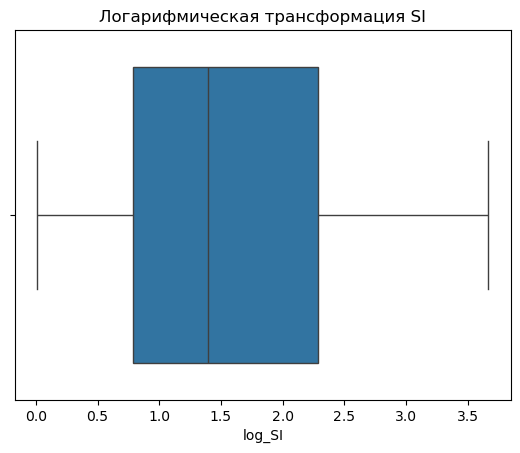

In [6]:
# Логарифмическая трансформация
df['log_SI'] = np.log(df['SI'] + 1)
sns.boxplot(x=df['log_SI'])
plt.title('Логарифмическая трансформация SI')
plt.show()

In [13]:
df = df.drop(df.columns[[0]], axis=1)
df.head()

,"CC50, mM",SI,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,log_SI
0,175.482382,28.125,5.094096,5.094096,0.387225,0.387225,0.417362,42.928571,384.652,340.300,...,0,0,0,0,0,0,0,3,0,3.371597
1,5.402819,7.000,3.961417,3.961417,0.533868,0.533868,0.462473,45.214286,388.684,340.300,...,0,0,0,0,0,0,0,3,0,2.079442
2,161.142320,0.720,2.627117,2.627117,0.543231,0.543231,0.260923,42.187500,446.808,388.344,...,0,0,0,0,0,0,0,3,0,0.542324
4,139.270991,1.300,5.150510,5.150510,0.270476,0.270476,0.429038,36.514286,466.713,424.377,...,0,0,0,0,0,0,0,0,0,0.832909
5,30.075821,2.000,5.758408,5.758408,0.278083,0.278083,0.711012,28.600000,332.491,304.267,...,0,0,0,0,0,0,0,0,0,1.098612


In [15]:
df = df.drop(df.columns[[0]], axis=1)

In [17]:
df = df.drop(df.columns[[0]], axis=1)

In [19]:
df = df.drop(df.columns[[0]], axis=1)
df.head()

,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,log_SI
0,5.094096,0.387225,0.387225,0.417362,42.928571,384.652,340.300,384.350449,158,0,...,0,0,0,0,0,0,0,3,0,3.371597
1,3.961417,0.533868,0.533868,0.462473,45.214286,388.684,340.300,388.381750,162,0,...,0,0,0,0,0,0,0,3,0,2.079442
2,2.627117,0.543231,0.543231,0.260923,42.187500,446.808,388.344,446.458903,186,0,...,0,0,0,0,0,0,0,3,0,0.542324
4,5.150510,0.270476,0.270476,0.429038,36.514286,466.713,424.377,466.334799,184,0,...,0,0,0,0,0,0,0,0,0,0.832909
5,5.758408,0.278083,0.278083,0.711012,28.600000,332.491,304.267,332.225249,130,0,...,0,0,0,0,0,0,0,0,0,1.098612


In [21]:
# анализ мультиколинеарности и отбор фичей
target_vars = ['log_SI']
numeric_features = df.select_dtypes(include=np.number)

# анализ корреляционной матрицы между признаками
corr_matrix = numeric_features.corr()
# пары признаков с высокой корреляцией (>0.8 или <-0.8)
high_corr_pairs = [(col1, col2, corr_matrix.loc[col1, col2])
                   for col1 in corr_matrix.columns for col2 in corr_matrix.columns
                   if col1 != col2 and abs(corr_matrix.loc[col1, col2]) > 0.8]
print("Пары признаков с высокой корреляцией (>0.8):")
for pair in high_corr_pairs:
    print(f"{pair[0]} и {pair[1]}: корреляция = {pair[2]:.2f}")

# VIF
vif_data = pd.DataFrame()
vif_data['feature'] = numeric_features.columns

vif_data['VIF'] = [variance_inflation_factor(numeric_features.values, i)
                   for i in range(numeric_features.shape[1])]
print("\nПризнаки с высоким VIF (более 5):")
for index, row in vif_data.iterrows():
    if row['VIF'] > 5:
        print(f"{row['feature']}: VIF = {row['VIF']:.2f}")

# корреляция признаков с целевыми переменными
corr_with_targets = pd.DataFrame(index=numeric_features.columns)
for target in target_vars:
    corr_with_targets[target] = numeric_features.corrwith(df[target])

# удаление признаков
features_to_remove = set()
for col1, col2, corr_value in high_corr_pairs:
    # проверка наличия высокой корреляции с таргетом у каждого признака
    corr_col1_targets = corr_with_targets.loc[col1].abs()
    corr_col2_targets = corr_with_targets.loc[col2].abs()

    col1_has_target_corr = any(corr_col1_targets > 0.2)
    col2_has_target_corr = any(corr_col2_targets > 0.2)
    if not col1_has_target_corr and not col2_has_target_corr:
        features_to_remove.add(col2)
print("\nПризнаки для удаления из-за мультиколлинеарности без связи с таргетом:")
for feature in features_to_remove:
    print(feature)

# итоговый набор признаков после удаления
final_features = [col for col in numeric_features.columns if col not in features_to_remove]
print("\nОставшиеся признаки после удаления:")
print(final_features)

df_final = df[final_features]

Пары признаков с высокой корреляцией (>0.8):
MinEStateIndex и fr_alkyl_halide: корреляция = -0.86
SPS и FractionCSP3: корреляция = 0.86
MolWt и HeavyAtomMolWt: корреляция = 1.00
MolWt и ExactMolWt: корреляция = 1.00
MolWt и NumValenceElectrons: корреляция = 0.98
MolWt и BertzCT: корреляция = 0.90
MolWt и Chi0: корреляция = 0.99
MolWt и Chi0n: корреляция = 0.94
MolWt и Chi0v: корреляция = 0.95
MolWt и Chi1: корреляция = 0.99
MolWt и Chi1n: корреляция = 0.90
MolWt и Chi1v: корреляция = 0.92
MolWt и Kappa1: корреляция = 0.96
MolWt и Kappa2: корреляция = 0.91
MolWt и LabuteASA: корреляция = 0.99
MolWt и HeavyAtomCount: корреляция = 0.99
MolWt и MolMR: корреляция = 0.96
HeavyAtomMolWt и MolWt: корреляция = 1.00
HeavyAtomMolWt и ExactMolWt: корреляция = 1.00
HeavyAtomMolWt и NumValenceElectrons: корреляция = 0.97
HeavyAtomMolWt и BertzCT: корреляция = 0.93
HeavyAtomMolWt и Chi0: корреляция = 0.98
HeavyAtomMolWt и Chi0n: корреляция = 0.91
HeavyAtomMolWt и Chi0v: корреляция = 0.93
HeavyAtomMol

In [22]:
df_final.head()

,MaxEStateIndex,MinAbsEStateIndex,qed,NumRadicalElectrons,BCUT2D_MRLOW,AvgIpc,BalabanJ,Ipc,PEOE_VSA10,PEOE_VSA11,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,log_SI
0,5.094096,0.387225,0.417362,0,0.193481,3.150503,1.164038,2.187750e+06,0.0,0.0,...,0,0,0,0,0,0,0,3,0,3.371597
1,3.961417,0.533868,0.462473,0,0.120322,3.150503,1.080362,2.187750e+06,0.0,0.0,...,0,0,0,0,0,0,0,3,0,2.079442
2,2.627117,0.543231,0.260923,0,-0.922902,3.214947,1.219066,8.610751e+06,0.0,0.0,...,0,0,0,0,0,0,0,3,0,0.542324
4,5.150510,0.270476,0.429038,0,0.193687,3.337074,1.136678,1.053758e+08,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0.832909
5,5.758408,0.278083,0.711012,0,0.193701,2.920513,1.523516,6.287748e+05,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1.098612


In [23]:
# 20 самых важных признаков
X = df_final.drop(columns=['log_SI'])
y = df_final['log_SI']

importances = mutual_info_regression(X, y)

feature_importances = pd.Series(importances, index=X.columns)
feature_importances = feature_importances.sort_values(ascending=False)

print("20 самых важных признаков для SI по их значимости:")
print(feature_importances.head(20))

20 самых важных признаков для SI по их значимости:
BCUT2D_MRLOW         0.178906
AvgIpc               0.177726
EState_VSA2          0.143887
MaxEStateIndex       0.139560
VSA_EState4          0.135606
qed                  0.134124
PEOE_VSA2            0.132027
VSA_EState8          0.127772
PEOE_VSA6            0.127293
MinAbsEStateIndex    0.123021
SlogP_VSA2           0.118975
NumAliphaticRings    0.118929
VSA_EState5          0.114890
VSA_EState7          0.114654
PEOE_VSA7            0.106581
MolLogP              0.104464
EState_VSA5          0.098305
PEOE_VSA9            0.097769
EState_VSA8          0.093044
EState_VSA3          0.092658
dtype: float64


In [24]:
# Удаляем признаки с важностью менее 0.05
features_to_keep = feature_importances[feature_importances >= 0.05].index
X_drop = X[features_to_keep]

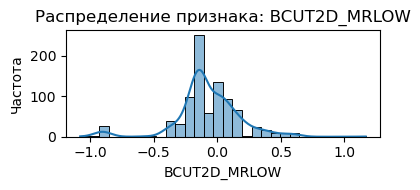

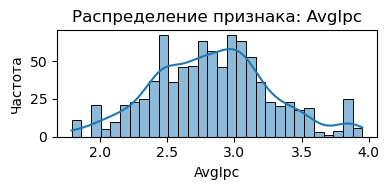

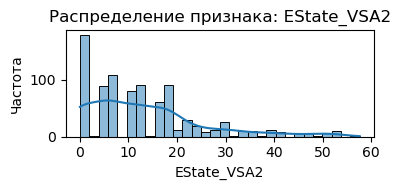

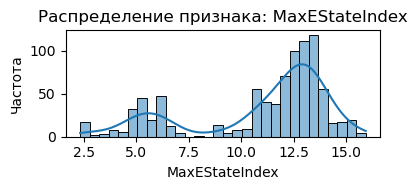

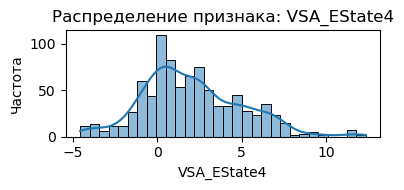

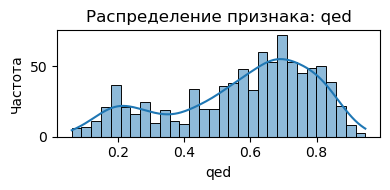

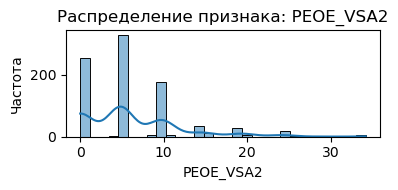

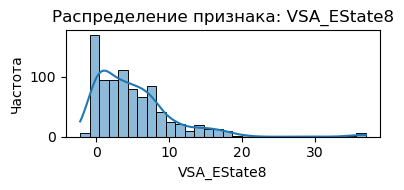

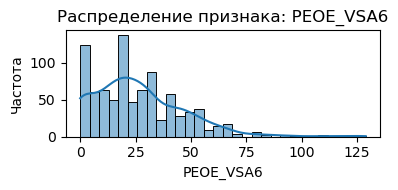

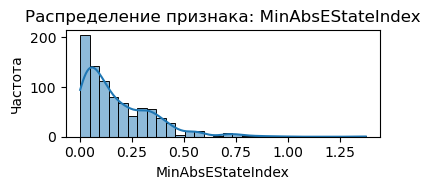

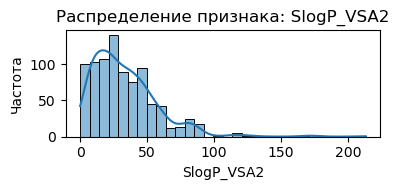

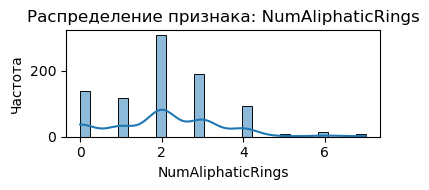

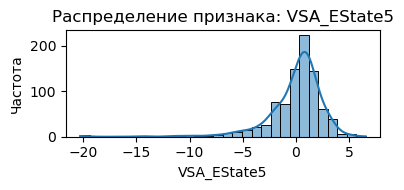

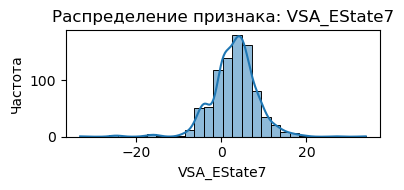

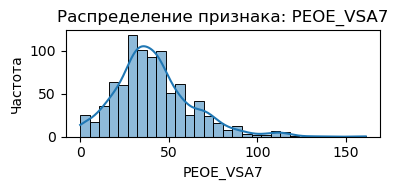

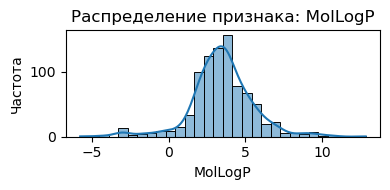

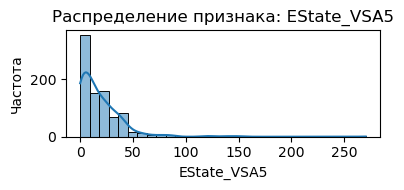

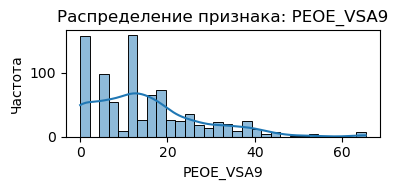

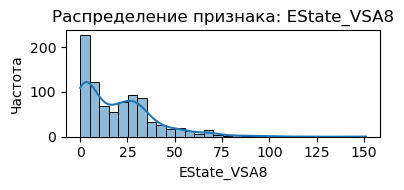

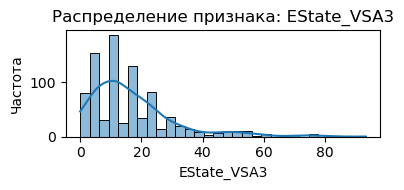

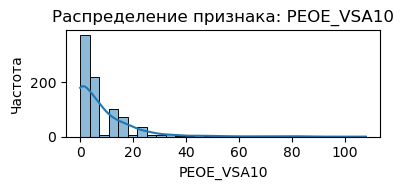

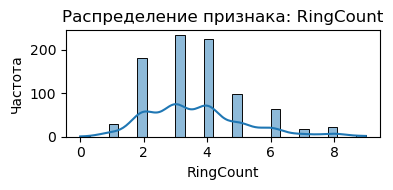

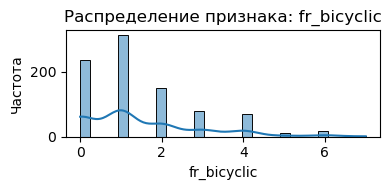

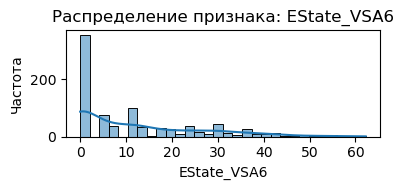

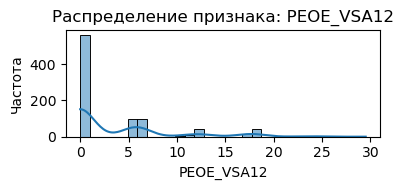

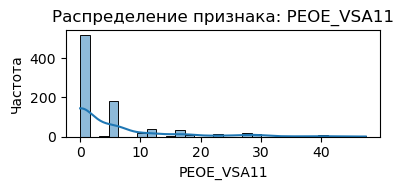

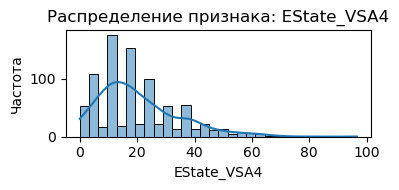

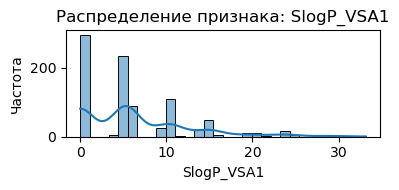

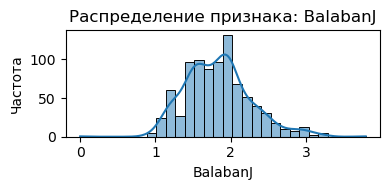

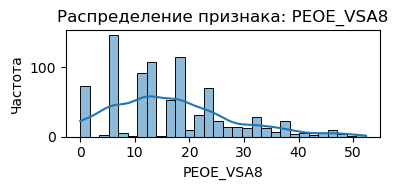

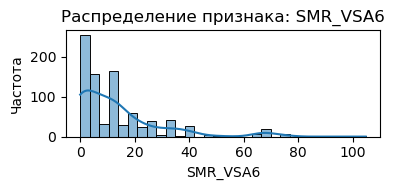

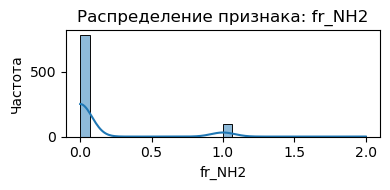

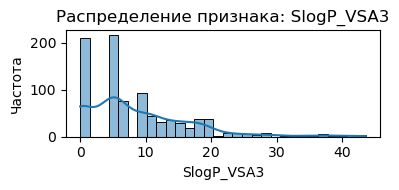

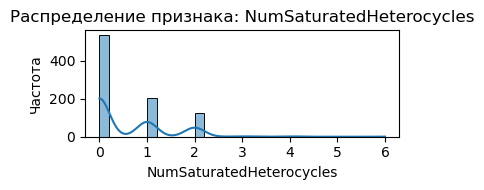

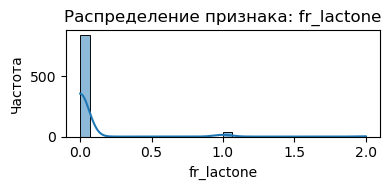

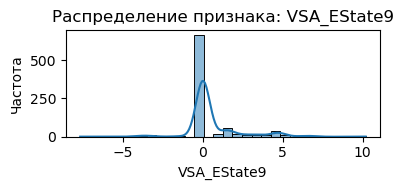

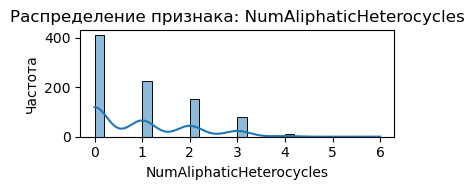

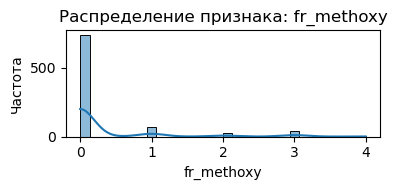

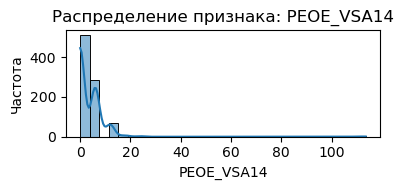

In [25]:
# построение графиков распределения оставшихся признаков
for feature in features_to_keep:
    plt.figure(figsize=(4, 2))
    sns.histplot(X_drop[feature], bins=30, kde=True)
    plt.title(f'Распределение признака: {feature}')
    plt.xlabel(feature)
    plt.ylabel('Частота')
    plt.tight_layout() 
    plt.show()

In [26]:
# логарифмизация признаков
skewness = X_drop.skew()
print(skewness[skewness.abs() > 1])
features_to_log = skewness[skewness > 1].index

print("Признаки для логарифмирования SI:", list(features_to_log))

for feature in features_to_log:
    min_value = X_drop[feature].min()
    if min_value <= 0:
        shift_value = abs(min_value) + 1e-9
        X_drop[feature] = np.log(X_drop[feature] + shift_value)
    else:
        X_drop[feature] = np.log(X_drop[feature])

EState_VSA2                  1.245235
MaxEStateIndex              -1.033696
PEOE_VSA2                    1.426571
VSA_EState8                  2.390408
PEOE_VSA6                    1.147189
MinAbsEStateIndex            1.658144
SlogP_VSA2                   1.805568
VSA_EState5                 -2.688860
EState_VSA5                  3.642878
PEOE_VSA9                    1.112554
EState_VSA8                  1.485438
EState_VSA3                  1.760583
PEOE_VSA10                   3.151679
fr_bicyclic                  1.184051
EState_VSA6                  1.131264
PEOE_VSA12                   1.733780
PEOE_VSA11                   2.211173
EState_VSA4                  1.099904
SlogP_VSA1                   1.263467
SMR_VSA6                     1.993307
fr_NH2                       2.552802
SlogP_VSA3                   1.345288
NumSaturatedHeterocycles     1.502712
fr_lactone                   5.256921
VSA_EState9                  1.624911
fr_methoxy                   2.811392
PEOE_VSA14  

In [27]:
# замена выбросов на границы интервала (IQR) для всех признаков
for feature in X_drop.columns:
    Q1 = X_drop[feature].quantile(0.25)
    Q3 = X_drop[feature].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    before_values = X_drop[feature].copy()
    X_drop.loc[X_drop[feature] < lower_bound, feature] = lower_bound
    X_drop.loc[X_drop[feature] > upper_bound, feature] = upper_bound
    
    num_lower_replacements = (before_values < lower_bound).sum()
    num_upper_replacements = (before_values > upper_bound).sum()
    
    print(f"В признаке '{feature}': заменено {num_lower_replacements} значений ниже нижней границы и {num_upper_replacements} выше верхней границы.")

В признаке 'BCUT2D_MRLOW': заменено 31 значений ниже нижней границы и 31 выше верхней границы.
В признаке 'AvgIpc': заменено 0 значений ниже нижней границы и 0 выше верхней границы.
В признаке 'EState_VSA2': заменено 178 значений ниже нижней границы и 0 выше верхней границы.
В признаке 'MaxEStateIndex': заменено 83 значений ниже нижней границы и 0 выше верхней границы.
В признаке 'VSA_EState4': заменено 0 значений ниже нижней границы и 10 выше верхней границы.
В признаке 'qed': заменено 0 значений ниже нижней границы и 0 выше верхней границы.
В признаке 'PEOE_VSA2': заменено 0 значений ниже нижней границы и 0 выше верхней границы.
В признаке 'VSA_EState8': заменено 4 значений ниже нижней границы и 0 выше верхней границы.
В признаке 'PEOE_VSA6': заменено 124 значений ниже нижней границы и 0 выше верхней границы.
В признаке 'MinAbsEStateIndex': заменено 23 значений ниже нижней границы и 0 выше верхней границы.
В признаке 'SlogP_VSA2': заменено 12 значений ниже нижней границы и 0 выше вер

In [28]:
X_drop.head()

,BCUT2D_MRLOW,AvgIpc,EState_VSA2,MaxEStateIndex,VSA_EState4,qed,PEOE_VSA2,VSA_EState8,PEOE_VSA6,MinAbsEStateIndex,...,PEOE_VSA8,SMR_VSA6,fr_NH2,SlogP_VSA3,NumSaturatedHeterocycles,fr_lactone,VSA_EState9,NumAliphaticHeterocycles,fr_methoxy,PEOE_VSA14
0,0.193481,3.150503,-0.019272,5.196755,4.807589,0.417362,2.301065,2.954484,3.996071,-0.948750,...,35.342864,2.571811,-20.723266,0.059398,-20.723266,-20.723266,2.038787,0,-20.723266,-20.723266
1,0.120322,3.150503,-0.019272,5.196755,2.153503,0.462473,-20.723266,2.989779,3.996071,-0.627606,...,12.083682,2.571811,-20.723266,0.059398,-20.723266,-20.723266,2.038787,0,-20.723266,-20.723266
2,-0.497976,3.214947,-0.019272,5.196755,2.184127,0.260923,-20.723266,3.020324,3.726715,-0.610221,...,23.671624,3.720383,-20.723266,0.059398,-20.723266,-20.723266,2.038787,0,-20.723266,-20.723266
4,0.193687,3.337074,2.382318,5.196755,9.071783,0.429038,2.301065,2.827493,4.186740,-1.307572,...,22.253351,-20.723266,-20.723266,1.859546,-20.723266,-20.723266,2.038787,0,-20.723266,-20.723266
5,0.193701,2.920513,1.689171,5.758408,9.848451,0.711012,1.607918,2.251554,3.807477,-1.279836,...,16.814062,1.746355,-20.723266,1.859546,-20.723266,-20.723266,2.038787,0,-20.723266,-20.723266


In [29]:
# стандартизация
std = StandardScaler()
std.fit(X_drop)
X_std = std.transform(X_drop)
X_std_df = pd.DataFrame(X_std, columns=X_drop.columns)
print("Стандартизированные данные:")
X_std_df.head()

Стандартизированные данные:


,BCUT2D_MRLOW,AvgIpc,EState_VSA2,MaxEStateIndex,VSA_EState4,qed,PEOE_VSA2,VSA_EState8,PEOE_VSA6,MinAbsEStateIndex,...,PEOE_VSA8,SMR_VSA6,fr_NH2,SlogP_VSA3,NumSaturatedHeterocycles,fr_lactone,VSA_EState9,NumAliphaticHeterocycles,fr_methoxy,PEOE_VSA14
0,1.298550,0.724858,-1.734476,-1.877487,0.958875,-0.742253,0.666743,1.693765,1.065858,1.068912,...,1.710809,0.626459,3.552714e-15,-1.557101,-0.801987,3.552714e-15,-4.440892e-16,-0.875316,3.552714e-15,-0.848923
1,0.926559,0.724858,-1.734476,-1.877487,0.039661,-0.530202,-1.563485,1.743497,1.065858,1.330309,...,-0.412132,0.626459,3.552714e-15,-1.557101,-0.801987,3.552714e-15,-4.440892e-16,-0.875316,3.552714e-15,-0.848923
2,-2.217324,0.872546,-1.734476,-1.877487,0.050268,-1.477619,-1.563485,1.786537,0.810394,1.344459,...,0.645537,0.734588,3.552714e-15,-1.557101,-0.801987,3.552714e-15,-4.440892e-16,-0.875316,3.552714e-15,-0.848923
3,1.299597,1.152424,0.265902,-1.877487,2.435731,-0.687365,0.666743,1.514832,1.246693,0.776847,...,0.516086,-1.566585,3.552714e-15,0.151914,-0.801987,3.552714e-15,-4.440892e-16,-0.875316,3.552714e-15,-0.848923
4,1.299672,0.197787,-0.311447,-1.697121,2.704721,0.638096,0.599602,0.703313,0.886991,0.799423,...,0.019625,0.548749,3.552714e-15,0.151914,-0.801987,3.552714e-15,-4.440892e-16,-0.875316,3.552714e-15,-0.848923


In [30]:
# нормализация
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X_drop)
X_normalized_df = pd.DataFrame(X_normalized, columns=X_drop.columns)
print("Нормализованные данные:")
X_normalized_df.head()

Нормализованные данные:


,BCUT2D_MRLOW,AvgIpc,EState_VSA2,MaxEStateIndex,VSA_EState4,qed,PEOE_VSA2,VSA_EState8,PEOE_VSA6,MinAbsEStateIndex,...,PEOE_VSA8,SMR_VSA6,fr_NH2,SlogP_VSA3,NumSaturatedHeterocycles,fr_lactone,VSA_EState9,NumAliphaticHeterocycles,fr_methoxy,PEOE_VSA14
0,0.774785,0.629530,0.000000,0.000000,0.650694,0.403059,0.949251,0.824632,0.789963,0.780575,...,0.729262,0.918050,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.692810,0.629530,0.000000,0.000000,0.466780,0.453877,0.000000,0.833301,0.789963,0.836195,...,0.249334,0.918050,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.659294,0.000000,0.000000,0.468902,0.226829,0.000000,0.840803,0.724401,0.839206,...,0.488439,0.963315,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.775016,0.715700,0.589560,0.000000,0.946181,0.416213,0.949251,0.793443,0.836371,0.718428,...,0.459174,0.000000,0.0,0.484615,0.0,0.0,0.0,0.0,0.0,0.0
4,0.775032,0.523307,0.419401,0.052311,1.000000,0.733859,0.920674,0.651990,0.744059,0.723232,...,0.346940,0.885519,0.0,0.484615,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
# разделение датасета на тестовую и тренировочную выборки
X_train, X_test, y_train, y_test = train_test_split(X_drop, y, test_size=0.15, random_state=42)

print(f'Train dataset size: {X_train.shape}, {y_train.shape}')
print(f'Train dataset size: {X_test.shape}, {y_test.shape}')

Train dataset size: (744, 39), (744,)
Train dataset size: (132, 39), (132,)


### Обучение моделей

In [32]:
models = {
    'Linear Regression': Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('model', LinearRegression())
    ]),
    'Ridge Regression': Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('model', Ridge())
    ]),
    'KNN (KNeighborsRegressor)': Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('model', KNeighborsRegressor(n_neighbors=5))
    ]),
    'Random Forest': Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('model', RandomForestRegressor(random_state=42))
    ]),
    'Gradient Boosting': Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('model', GradientBoostingRegressor(random_state=42))
    ]),
    'HistGradientBoosting': Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('model', HistGradientBoostingRegressor(random_state=42))
    ]),
    'AdaBoost': Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('model', AdaBoostRegressor(random_state=42))
    ]),
    'XGBoost': Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('model', xgb.XGBRegressor(random_state=42, verbosity=0))
    ]),
    'LightGBM': Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('model', lgb.LGBMRegressor(random_state=42))
    ]),
    'CatBoost Regressor': Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('model', CatBoostRegressor(
            random_seed=42,
            verbose=0 
        ))
    ])
}

# обучение и оценка моделей
results = {}
for name, pipeline in models.items():
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {'MSE': mse, 'MAE': mae, 'R2': r2}
    
    print(f"{name}: MSE = {mse:.2f}, MAE = {mae:.2f}, R2 = {r2:.2f}")

# подбор гиперпараметров для лучшей модели
param_grid_cb = {
    'model__iterations': [100, 200],
    'model__depth': [4, 6],
    'model__learning_rate': [0.01, 0.1],
}

grid_search_cb = GridSearchCV(
    models['CatBoost Regressor'],
    param_grid_cb,
    cv=5,
    scoring='neg_mean_squared_error'
)

grid_search_cb.fit(X_train, y_train)

Linear Regression: MSE = 0.73, MAE = 0.70, R2 = 0.11
Ridge Regression: MSE = 0.73, MAE = 0.70, R2 = 0.11
KNN (KNeighborsRegressor): MSE = 0.92, MAE = 0.71, R2 = -0.12
Random Forest: MSE = 0.83, MAE = 0.70, R2 = -0.01
Gradient Boosting: MSE = 0.81, MAE = 0.72, R2 = 0.01
HistGradientBoosting: MSE = 0.89, MAE = 0.70, R2 = -0.08
AdaBoost: MSE = 0.80, MAE = 0.77, R2 = 0.02
XGBoost: MSE = 0.92, MAE = 0.70, R2 = -0.12
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000391 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4764
[LightGBM] [Info] Number of data points in the train set: 744, number of used features: 35
[LightGBM] [Info] Start training from score 1.632240
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('imputer',
                                        SimpleImputer(strategy='median')),
                                       ('model',
                                        <catboost.core.CatBoostRegressor object at 0x0000017535FC9850>)]),
             param_grid={'model__depth': [4, 6],
                         'model__iterations': [100, 200],
                         'model__learning_rate': [0.01, 0.1]},
             scoring='neg_mean_squared_error')

╒═══════════════════════════╤════════╤════════╤═════════╕
│                           │    MSE │    MAE │      R2 │
╞═══════════════════════════╪════════╪════════╪═════════╡
│ Linear Regression         │ 0.7312 │ 0.6978 │  0.1086 │
├───────────────────────────┼────────┼────────┼─────────┤
│ Ridge Regression          │ 0.7310 │ 0.6978 │  0.1087 │
├───────────────────────────┼────────┼────────┼─────────┤
│ KNN (KNeighborsRegressor) │ 0.9157 │ 0.7146 │ -0.1165 │
├───────────────────────────┼────────┼────────┼─────────┤
│ Random Forest             │ 0.8284 │ 0.6953 │ -0.0100 │
├───────────────────────────┼────────┼────────┼─────────┤
│ Gradient Boosting         │ 0.8089 │ 0.7183 │  0.0138 │
├───────────────────────────┼────────┼────────┼─────────┤
│ HistGradientBoosting      │ 0.8863 │ 0.7047 │ -0.0806 │
├───────────────────────────┼────────┼────────┼─────────┤
│ AdaBoost                  │ 0.8049 │ 0.7727 │  0.0187 │
├───────────────────────────┼────────┼────────┼─────────┤
│ XGBoost     

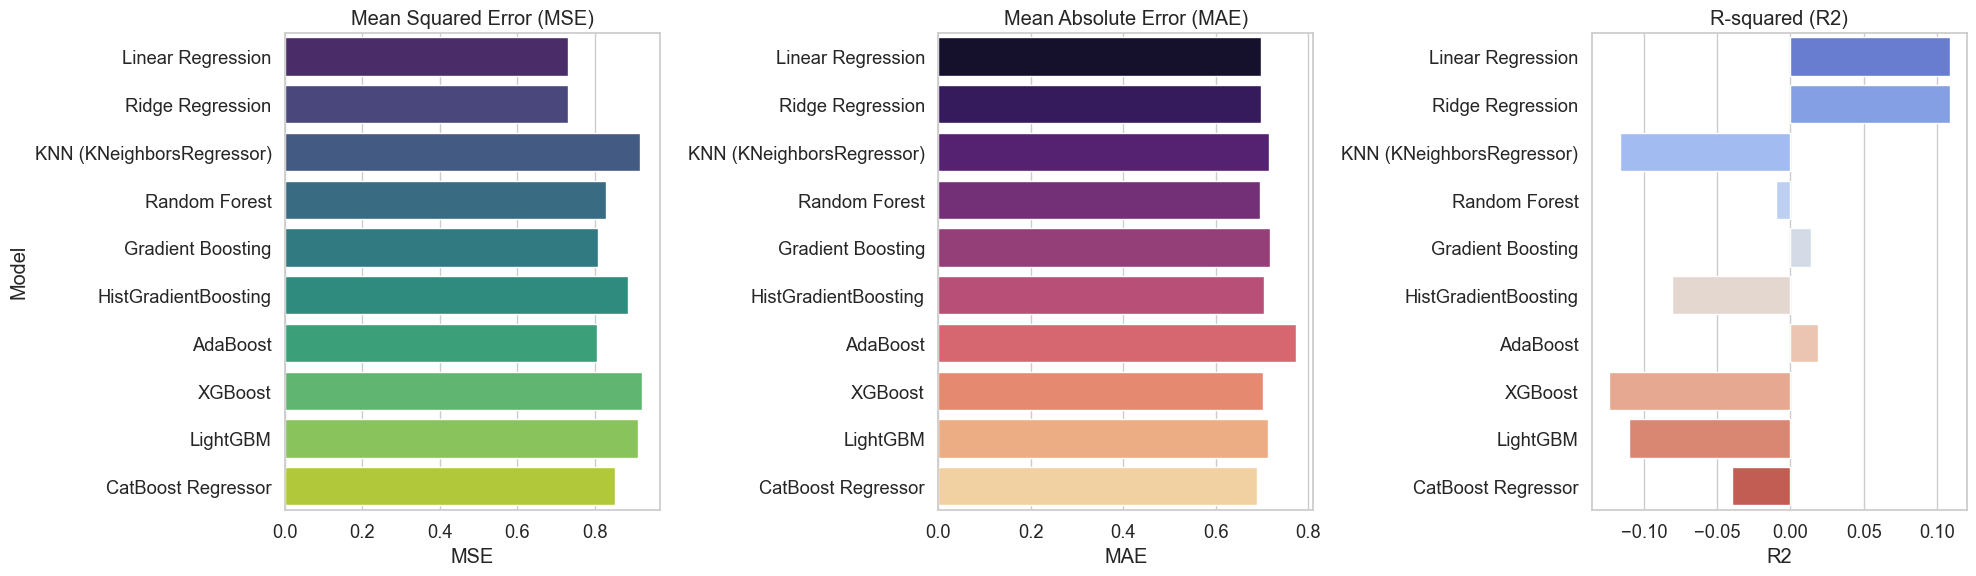

In [33]:
# визуализация результатов
results_df = pd.DataFrame(results).T  
print(tabulate(results_df, headers='keys', tablefmt='fancy_grid', floatfmt=".4f"))


results_df = pd.DataFrame(results).T 
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

sns.barplot(
    x='MSE',
    y=results_df.index,
    data=results_df,
    ax=axes[0],
    palette='viridis'
)
axes[0].set_title('Mean Squared Error (MSE)')
axes[0].set_xlabel('MSE')
axes[0].set_ylabel('Model')

sns.barplot(
    x='MAE',
    y=results_df.index,
    data=results_df,
    ax=axes[1],
    palette='magma'
)
axes[1].set_title('Mean Absolute Error (MAE)')
axes[1].set_xlabel('MAE')
axes[1].set_ylabel('')

sns.barplot(
    x='R2',
    y=results_df.index,
    data=results_df,
    ax=axes[2],
    palette='coolwarm'
)
axes[2].set_title('R-squared (R2)')
axes[2].set_xlabel('R2')
axes[2].set_ylabel('')

plt.tight_layout()
plt.show()

In [34]:
# вычисление MAPE
results_mape = []

for name, pipeline in models.items():
    y_pred = pipeline.predict(X_test)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    results_mape.append({'Модель': name, 'MAPE': mape})

results_df = pd.DataFrame(results_mape).sort_values(by='MAPE')

print(results_df.to_string(index=False))

                   Модель     MAPE
KNN (KNeighborsRegressor) 0.841583
         Ridge Regression 0.855423
        Linear Regression 0.855511
                  XGBoost 0.878489
       CatBoost Regressor 0.880606
                 LightGBM 0.891916
     HistGradientBoosting 0.892500
        Gradient Boosting 0.893861
            Random Forest 0.910293
                 AdaBoost 0.988507


In [35]:
# подбор гиперпараметров
param_grids = {
    'Linear Regression': {},
    'Ridge Regression': {
        'model__alpha': [0.1, 1.0, 10.0]
    },
    'KNN (KNeighborsRegressor)': {
        'model__n_neighbors': [3, 5, 7],
        'model__weights': ['uniform', 'distance']
    },
    'Random Forest': {
        'model__n_estimators': [100, 200],
        'model__max_depth': [None, 10, 20],
        'model__min_samples_split': [2, 5]
    },
    'Gradient Boosting': {
        'model__n_estimators': [100, 200],
        'model__learning_rate': [0.01, 0.1],
        'model__max_depth': [3, 5]
    },
    'HistGradientBoosting': {
        'model__max_iter': [100, 200],
        'model__max_depth': [None, 10]
    },
    'AdaBoost': {
        'model__n_estimators': [50, 100],
        'model__learning_rate': [0.01, 0.1]
    },
    'XGBoost': {
        'model__n_estimators': [100, 200],
        'model__max_depth': [3, 6],
        'model__learning_rate': [0.01, 0.1]
    },
    'LightGBM': {
        'model__n_estimators': [100, 200],
        'model__num_leaves': [31, 50],
        'model__learning_rate': [0.01, 0.1]
    },
    'CatBoost Regressor': {
        'model__iterations': [100, 200],
        'model__depth': [4, 6],
        'model__learning_rate': [0.01, 0.1]
    }
}

results = []

for name in models:
    print(f"\nОбучение и подбор гиперпараметров для {name}...")
    
    grid = GridSearchCV(
        models[name],
        param_grids.get(name, {}),
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )
    
    grid.fit(X_train, y_train)
    
    best_params = grid.best_params_
    

    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results.append({
        "Model": name,
        "Best Params": best_params,
        "MSE": mse,
        "MAE": mae,
        "R2": r2
     })

results_df = pd.DataFrame(results)
results_df['MSE'] = results_df['MSE'].round(3)
results_df['MAE'] = results_df['MAE'].round(3)
results_df['R2'] = results_df['R2'].round(3)

results_df['Best Params'] = results_df['Best Params'].apply(lambda x: str(x))

print("\nРезультаты моделей:")
print(tabulate(results_df.sort_values(by='R2'), headers='keys', tablefmt='fancy_grid', showindex=False))


Обучение и подбор гиперпараметров для Linear Regression...

Обучение и подбор гиперпараметров для Ridge Regression...

Обучение и подбор гиперпараметров для KNN (KNeighborsRegressor)...

Обучение и подбор гиперпараметров для Random Forest...

Обучение и подбор гиперпараметров для Gradient Boosting...

Обучение и подбор гиперпараметров для HistGradientBoosting...

Обучение и подбор гиперпараметров для AdaBoost...

Обучение и подбор гиперпараметров для XGBoost...

Обучение и подбор гиперпараметров для LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000409 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4764
[LightGBM] [Info] Number of data points in the train set: 744, number of used features: 35
[LightGBM] [Info] Start training from score 1.632240
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai